# Using different fairness metrics

In this notebook we'll build up a scan definition to perform multiple fairness analyses other than the burden-based
default used by the Certifai counterfcatual framework.

Specifically we'll look at two widely used measures of fairness detailed below.  For the purposes of discussion we will define things in terms of the following random variables:

* `X` - the input to the model (i.e. - the features)
* `C` - the class predicted by the model
* `Y` - the actual (ground truth) class
* `G` - the protected group membership.  Note that if the protected grouping feature is included in the data given to the model then for some deterministic `f`, `G = f(X)`.  However, this need not be the case (when it is not the model is said the be trained with 'fairness by unawareness' (which has no theoretical guarantees in regard to actual achieved fairness)

## Demographic Parity

A predictor is said the be fair under *Demographic Parity* if the chances of a random member of each protected group
has the same probability of the favorable prediction.  For example a predictor of whether some one is going to be
offered a job, would be fair with respect to demographic parity and (simple binary) gender-based protected groups is it awarded jobs to men and women with equal likelihood.

Techanically this may be stated as `C ⟂ G`

This is a very intuitive measure, but note that it takes no account of ground truth (i.e. - whether under some objective measure a person *should* be awarded the job in this case).  As a result a 'perfect'predictor which is 100%
accurate according to ground truth may not necessarily be fair under this metric.

## Equal opportunity

A predictor is said to be fair under *Equality of Opportunity* if the chances of a random member of each protected group *who should receive the favorable prediction according to ground truth* has the same probability of the favorable prediction.

Technically this may be stated as `C ⟂ G | Y=1`

This measure determines whether the predictive model is unbiased relative to a perfect decision process, and is always satisfied by a 100% accurate predictor.

Both of the above measures are binary definitions of what it measn to be completely fair (under the respective definitions of fairness).  We will turn them into soft measures by looking at how close the model is to achieving them.  Specifically we will look at the measure for each class. These are empirical rate estimates of the probabilities, so for the two definitions above respectively:

`P(C | G=g)` for each `g ∈ G`; and

`P(C | Y=1, G=g)`

The result is a list of values, one for each protected group, which we then measure the disparity between to provide
a soft measure of fairness (all of them being equal implies perfect fairness).  The actual formula used is to turn the disparity into a [0, 1] measure (1 being perfectly fair) is:

`(max(P) - min(P))/max(P ∪ (1 - P))`, using `P` as shorthand for the relevant conditional probabilities above.

In [3]:
import pandas as pd
import matplotlib as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from copy import copy

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue)
from certifai.scanner.report_utils import scores, construct_scores_dataframe

In [4]:
# special import - 
# for multiprocessing to work in a Notebook,  pickled classes must be in a separate package or notebook
# hence, the encoder class has to be somewhere other than the current notebook
# from ipynb.fs.defs.cat_encoder import CatEncoder # <- doesn't work on Azure Notebooks
# %run cat_encoder.py # <- doesn't work because code doesn't remain external

# Azure Notebooks workaround - 
import os
import sys
sys.path.append("../utils")
from cat_encoder import CatEncoder

In [5]:
# Example will use a simple logistic classifier on the German Credit dataset
base_path = '..'
all_data_file = f"{base_path}/datasets/german_credit_eval.csv"

df = pd.read_csv(all_data_file)

cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'status',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

label_column = 'outcome'

# Separate outcome
y = df[label_column]
X = df.drop(label_column, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Note - to support python multi-processing in the context of a notebook the encoder MUST
# be in a separate file, which is why `CatEncoder` is defined outside of this notebook
encoder = CatEncoder(cat_columns, X)

def build_model(data, name, model_family, test=None):
    if test is None:
        test = data
        
    if model_family == 'SVM':
        parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, .5, 1, 2, 4, 10], 'gamma':['auto']}
        m = svm.SVC()
    elif model_family == 'logistic':
        parameters = {'C': (0.5, 1.0, 2.0), 'solver': ['lbfgs'], 'max_iter': [1000]}
        m = LogisticRegression()
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(data[0], data[1])

    # Assess on the test data
    accuracy = model.score(test[0], test[1].values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model

svm_model = build_model((encoder(X_train.values), y_train),
                        'Support Vector Machine',
                        'SVM',
                        test=(encoder(X_test.values), y_test))

logistic_model = build_model((encoder(X_train.values), y_train),
                        'Logistic classifier',
                        'logistic',
                        test=(encoder(X_test.values), y_test))

Model 'Support Vector Machine' accuracy is 0.77
Model 'Logistic classifier' accuracy is 0.77


In [6]:
# Wrap the model up for use by Certifai as a local model
svm_model_proxy = CertifaiPredictorWrapper(svm_model, encoder=encoder)
logistic_model_proxy = CertifaiPredictorWrapper(logistic_model, encoder=encoder)

In [7]:
# Create the scan object

# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

scan = CertifaiScanBuilder.create('test_user_case',
                                  prediction_task=task)

# Add our local models
first_model = CertifaiModel('SVM',
                            local_predictor=svm_model_proxy)
scan.add_model(first_model)
second_model = CertifaiModel('logistic',
                            local_predictor=logistic_model_proxy)
scan.add_model(second_model)

# Add the eval dataset
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.csv(all_data_file))
scan.add_dataset(eval_dataset)

# Setup an evaluation for fairness on the above dataset using the model
# We'll look at disparity between groups defined by marital status and age
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('age'))
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('status'))
scan.add_evaluation_type('fairness')
scan.evaluation_dataset_id = 'evaluation'

# Rather than Certifai's default burden-based fairness analysis of counterfactuals, we'll specify instead
# some other measures of fairness.
scan.add_fairness_metric('demographic parity')
scan.add_fairness_metric('equal opportunity')

# The primary metric selects the one that would be used as the fairness component in the ATX score
scan.primary_fairness_metric = 'demographic parity'

# For the purposes of this example we'll drop th default analysis that uses counterfactual burden
scan.remove_fairness_metric('burden')

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'outcome'

# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
result = scan.run(write_reports=False)

2020-05-28 12:07:07,138 root   WARNING  Insufficient examples of some fairness classes for convergence (smallest class size is for 'male : divorced/separated' with 50 samples)


Starting scan with model_use_case_id: 'test_user_case' and scan_id: 'da2af7d71d79'
[--------------------] 2020-05-28 12:07:07.058218 - 0 of 2 reports (0.0% complete) - Running fairness evaluation for model: SVM


2020-05-28 12:08:44,131 root   WARNING  Insufficient examples of some fairness classes for convergence (smallest class size is for 'male : divorced/separated' with 50 samples)


[##########----------] 2020-05-28 12:08:44.090436 - 1 of 2 reports (50.0% complete) - Running fairness evaluation for model: logistic
[####################] 2020-05-28 12:10:18.398015 - 2 of 2 reports (100.0% complete) - Completed all evaluations


## Score Extraction

Having run the analysis, we now extract the detailed scores from the results as a DataFrame.  The columns have the following interpretation:

* overall fairness - fairness of the model across all protected features (this is just a min over protected feature fairness - i.e. - `min(Feature(age), Feature(status)` in this case)
* individual feature fairness (e.g. - `Feature (age)` - soft fairness measure with respect to a particular protected feature
* Group details (&lt;group&gt;) - the actual empirical probability (rate) relevant to the fairness metric concerned for a specific group

In [8]:
# Extract the scores
score_df = construct_scores_dataframe(scores('fairness', result), include_confidence=True)
display(score_df)

,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (age),Feature (age) lower bound,Feature (age) upper bound,Group details (<= 25 years),Group details (<= 25 years) lower bound,...,Group details (female : divorced/separated/married) upper bound,Group details (male : divorced/separated),Group details (male : divorced/separated) lower bound,Group details (male : divorced/separated) upper bound,Group details (male : married/widowed),Group details (male : married/widowed) lower bound,Group details (male : married/widowed) upper bound,Group details (male : single),Group details (male : single) lower bound,Group details (male : single) upper bound
SVM (demographic parity),SVM,demographic parity,77.187060,70.628781,83.465415,79.321750,72.205243,86.538462,0.635468,0.580460,...,0.723127,0.740000,0.631579,0.833333,0.837500,0.769231,0.896226,0.810193,0.781955,0.837476
SVM (equal opportunity),SVM,equal opportunity,87.140498,78.813559,92.438472,89.380531,82.557638,95.244171,0.835165,0.773109,...,0.912821,0.869565,0.750000,0.962963,0.927536,0.867647,0.972603,0.945409,0.925659,0.962500
logistic (demographic parity),logistic,demographic parity,72.727273,61.198653,79.922243,76.554416,68.890764,84.568050,0.614973,0.554404,...,0.712460,0.641509,0.519231,0.750000,0.825581,0.762376,0.890909,0.823308,0.796578,0.849810
logistic (equal opportunity),logistic,equal opportunity,77.575758,63.410853,86.640976,84.183486,76.362489,91.301810,0.772727,0.701923,...,0.882075,0.736842,0.594595,0.864865,0.896552,0.830189,0.952381,0.933162,0.911765,0.952494


## Visualization

We can extract and plot summary and details.  Here we look at the soft fairness measure for each feature, and overall for the two models.

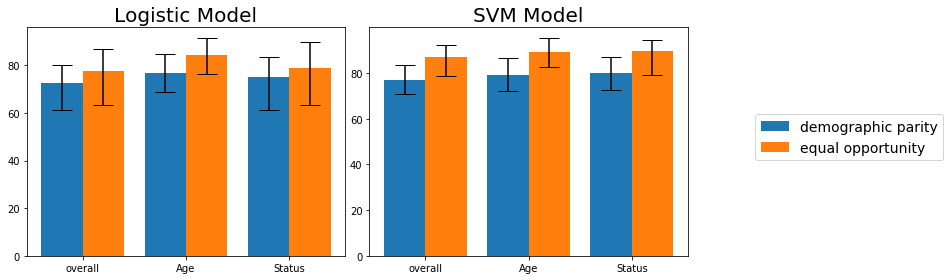

In [9]:
# Let's visualize this to see how the two different measures compare for these models
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,4])
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

def plot_model_results(ax, title, data, lower, upper, add_labels=False):
    ax.set_title(title, fontsize=20)
   
    metrics = data['type']
    all_values = data.drop('type', axis=1)

    ax.set_yticks(range(0,100,20))
    ax.set_xticks(np.arange(len(all_values.columns))+width)
    ax.set_xticklabels(all_values.columns)
    
    for idx in range(len(data)):
        values = list(all_values.iloc[idx])
        lowers = list(lower.iloc[idx])
        uppers = list(upper.iloc[idx])
        lower_errs = [values[i] - lowers[i] for i in range(len(lowers))]
        upper_errs = [uppers[i] - values[i] for i in range(len(uppers))]
        metric = metrics.iloc[idx]

        ax.bar([width/2+idx*width+f_idx for f_idx in range(len(all_values.columns))],
               values,
               width,
               color=colors[idx],
               label=metric if add_labels else None,
               yerr=[lower_errs, upper_errs],
               capsize=10)


displayed_stats = ['overall fairness', 'Feature (age)', 'Feature (status)']
plot_columns = score_df[['type'] + displayed_stats]
plot_columns.columns = ['type', 'overall', 'Age', 'Status']
column_lower_bounds = score_df[[f + ' lower bound' for f in displayed_stats]]
column_upper_bounds = score_df[[f + ' upper bound' for f in displayed_stats]]
plot_model_results(ax1,
                   "Logistic Model",
                   plot_columns[score_df['context'] == 'logistic'],
                   column_lower_bounds[score_df['context'] == 'logistic'],
                   column_upper_bounds[score_df['context'] == 'logistic'],
                   add_labels=True)
plot_model_results(ax2,
                   "SVM Model",
                   plot_columns[score_df['context'] == 'SVM'],
                   column_lower_bounds[score_df['context'] == 'SVM'],
                   column_upper_bounds[score_df['context'] == 'SVM'])

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8)   

plt.show()

## Commentary

Both models fair reasonably well, with the SVM having a slight edge.  It is interesting to note that fairness is largely the same in terms of both the protected features we analyzed here for the SVM, but that the logistic regression model is considerably more biased on `status` than it is on `age`

## Visualization of details

Let's look at the detailed rates that lie behind the demographic parity measure.  for this binary clasification task this is essentially just the positive predictive rate of the model for each protected group.

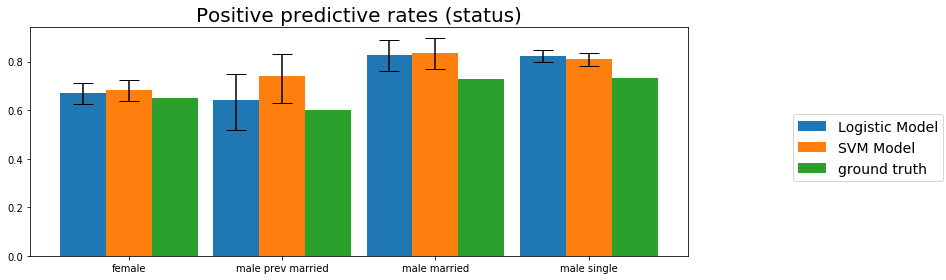

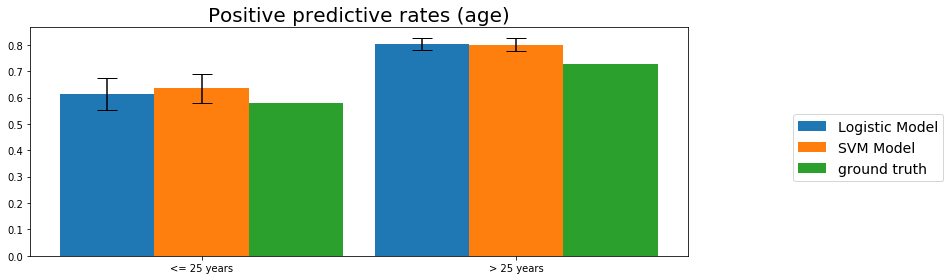

In [10]:
# The score details for each fairness type tell us the relevant rates (empirical probabilities) associated
# with each group. For instance, for demographic parity this will be the positive prediction rate for the group

# Let's plot this for the 'status' feature
fig, ax = plt.subplots(figsize=[12,4])
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.3

def plot_detail_results(ax, label, data, lower, upper, idx = 0):
    all_values = data
    
    ax.set_xticks(np.arange(len(all_values.columns))+width)
    ax.set_xticklabels(all_values.columns)
    
    values = list(all_values.iloc[0])
    lowers = list(lower.iloc[0])
    uppers = list(upper.iloc[0])
    lower_errs = [values[i] - lowers[i] for i in range(len(lowers))]
    upper_errs = [uppers[i] - values[i] for i in range(len(uppers))]
    
    ax.bar([c + idx*width for c in range(len(all_values.columns))],
           values,
           width,
           color=colors[idx],
           label=label,
           yerr = [lower_errs, upper_errs],
           capsize=10)

def plot_ground_truth(ax, data, feature_column, groups, offset, color, label):
    rates = []
    for g in groups:
        group_data = df[df[feature_column] == g]
        rates.append(sum(group_data['outcome'] == 1)/len(group_data))

    ax.bar([c + offset for c in range(len(rates))],
            rates,
            width,
            color=color,
            label=label,
            capsize=10)
    
ax.set_title("Positive predictive rates (status)", fontsize=20)

status_groups = [
    'female : divorced/separated/married',
    'male : divorced/separated',
    'male : married/widowed',
    'male : single'
]
plot_columns = score_df[[f'Group details ({x})' for x in status_groups]]
plot_columns.columns = ['female', 'male prev married', 'male married', 'male single']
column_lower_bounds = score_df[[f'Group details ({x}) lower bound' for x in status_groups]]
column_upper_bounds = score_df[[f'Group details ({x}) upper bound' for x in status_groups]]
plot_detail_results(ax,
                    "Logistic Model",
                    plot_columns[(score_df['context'] == 'logistic') & (score_df['type'] == 'demographic parity')],
                    column_lower_bounds[(score_df['context'] == 'logistic') & (score_df['type'] == 'demographic parity')],
                    column_upper_bounds[(score_df['context'] == 'logistic') & (score_df['type'] == 'demographic parity')])
plot_detail_results(ax,
                    "SVM Model",
                    plot_columns[(score_df['context'] == 'SVM') & (score_df['type'] == 'demographic parity')],
                    column_lower_bounds[(score_df['context'] == 'SVM') & (score_df['type'] == 'demographic parity')],
                    column_upper_bounds[(score_df['context'] == 'SVM') & (score_df['type'] == 'demographic parity')],
                    idx=1) 
plot_ground_truth(ax,
                  df,
                  'status',
                  status_groups,
                  width*2,
                  colors[2],
                  'ground truth')

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8)   

plt.show()

# And similarly for the 'age' feature
fig, ax = plt.subplots(figsize=[12,4])
    
ax.set_title("Positive predictive rates (age)", fontsize=20)

status_groups = [
    '<= 25 years',
    '> 25 years'
]
plot_columns = score_df[[f'Group details ({x})' for x in status_groups]]
plot_columns.columns = status_groups
column_lower_bounds = score_df[[f'Group details ({x}) lower bound' for x in status_groups]]
column_upper_bounds = score_df[[f'Group details ({x}) upper bound' for x in status_groups]]
plot_detail_results(ax,
                    "Logistic Model",
                    plot_columns[(score_df['context'] == 'logistic') & (score_df['type'] == 'demographic parity')],
                    column_lower_bounds[(score_df['context'] == 'logistic') & (score_df['type'] == 'demographic parity')],
                    column_upper_bounds[(score_df['context'] == 'logistic') & (score_df['type'] == 'demographic parity')])
plot_detail_results(ax,
                    "SVM Model",
                    plot_columns[(score_df['context'] == 'SVM') & (score_df['type'] == 'demographic parity')],
                    column_lower_bounds[(score_df['context'] == 'SVM') & (score_df['type'] == 'demographic parity')],
                    column_upper_bounds[(score_df['context'] == 'SVM') & (score_df['type'] == 'demographic parity')],
                    idx=1) 
plot_ground_truth(ax,
                  df,
                  'age',
                  status_groups,
                  width*2,
                  colors[2],
                  'ground truth')

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8)   

plt.show()

## Comments

Some Interesting take-outs from the above:

* We can readily see that the model if significantly more likely to give a positive predictions for the both the older age group, and males who have not gone through a divorce.

* The positive rates for the ground truth are also not even, so this is a case where the perfect predictor would not itself be fair under demographic parity.  This implies that a major source of bias (under this definition) is the training data itself.

* Both models systemically over-estimate the positive rate for *all* groups.  This is not in itself a fairness issue, but it is telling us something about a pathology in our modelling.

* The discrepancy in positive predictive rates for both models is greater than that exhibited by the ground truth, so in both cases the models are amplifying the bias displayed by the ground truth.